In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mlxtend.frequent_patterns import apriori, association_rules

In [2]:
#read in all data from a prototype toothbrush survey that comprises of 21 respondents
res_id = 'Respondents ID'
geninfo_df = pd.read_excel('Product Survey Data.xlsx', sheet_name='General Info', index_col=res_id)
likes_df = pd.read_excel('Product Survey Data.xlsx', sheet_name='Likes', index_col=res_id)
dislikes_df = pd.read_excel('Product Survey Data.xlsx', sheet_name='Dislikes', index_col=res_id)
charrate_df = pd.read_excel('Product Survey Data.xlsx', sheet_name='CharacteristicsRating', index_col=res_id)
willingtopayfeat_df = pd.read_excel('Product Survey Data.xlsx', sheet_name='PayingForFeatures', index_col=res_id)
mostwantedfeat_df = pd.read_excel('Product Survey Data.xlsx', sheet_name='MostWantedFeatures', index_col=res_id)

In [5]:
#Setting general plot parameters
SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Text(0, 0.5, 'Willingness to Pay')

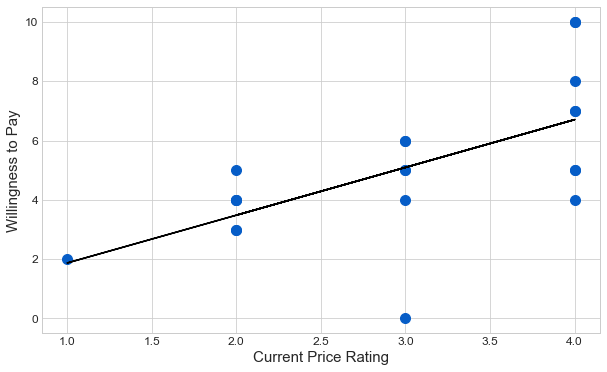

In [6]:
#scatter plot and linear regression analysis by comparing respondents current price rating and their willingness to pay
currentpricerating_x = geninfo_df['CurrentPriceRating(1-5)']
willingnesstopay_y = geninfo_df['WillingnessToPay']
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(10, 6))

#plotting scatter plot
plt.scatter(currentpricerating_x, willingnesstopay_y, s=100, c='#065dc7')

#obtaining slope and intercept for best-fit line
m, b = np.polyfit(currentpricerating_x, willingnesstopay_y, 1)

#plotting best-fit line
plt.plot(currentpricerating_x, m*currentpricerating_x + b, c='#000000')

plt.xlabel('Current Price Rating')
plt.ylabel('Willingness to Pay')

In [7]:
#Actual correlation coefficient values using pearson method 
geninfo_df[['CurrentPriceRating(1-5)', 'WillingnessToPay']].corr(method='pearson')

,CurrentPriceRating(1-5),WillingnessToPay
CurrentPriceRating(1-5),1.000000,0.635169
WillingnessToPay,0.635169,1.000000


In [8]:
#average rating of each characteristic of the product
avgchar_rate = charrate_df.loc[:, 'Grip':'Packaging'].mean()
avgchar_rate

Grip                  4.000000
Weight                3.380952
On/Off                3.714286
Clean/Rinse           4.428571
Vibration             3.523810
Waterproof            3.761905
Travel                3.380952
Replace Battery       4.000000
Replace Brush Head    4.238095
Replacements          4.523810
Avail in Area         4.714286
Long Battery Life     4.380952
Technology            2.571429
Looks Cool            2.571429
Distinguishable       3.476190
Match Décor           1.619048
Easy to Store         3.428571
Small Space           3.047619
Easy to hold          4.047619
Toothbrush Sized      3.190476
Packaging             2.142857
dtype: float64

Text(0, 0.5, 'Charateristics')

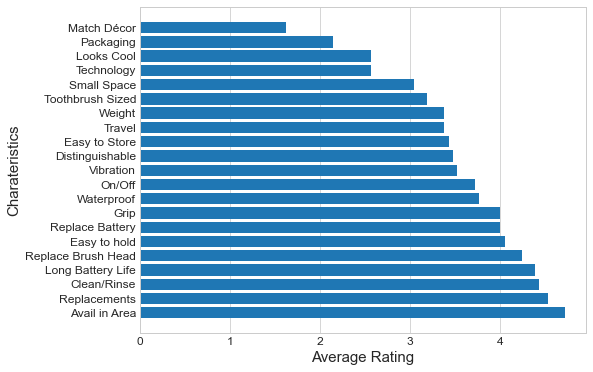

In [9]:
#horizontal bar chart to visualise average characteristics rating
plt.figure(figsize=(8, 6))
plt.grid(b=None, which='both', axis='y')
plt.barh(avgchar_rate.sort_values(ascending=False).index, avgchar_rate.sort_values(ascending=False))
plt.xlabel('Average Rating')
plt.ylabel('Charateristics')

In [10]:
#Principal Component Analysis (dimensionality reduction) using results for how much
#respondents were willing to pay for individual features

x = willingtopayfeat_df.loc[:, 'Timer':'Extra head'].values
x = StandardScaler().fit_transform(x) # normalizing the features

# convert normalized features into dataframe using pandas
willingtopayfeat_cols = ['feature'+str(i) for i in range(x.shape[1])]
normalised_willingtopayfeat = pd.DataFrame(x,columns = willingtopayfeat_cols)

#reducing dimensions
pca_willingtopayfeat = PCA(n_components=2)
principalComponents_willingtopayfeat = pca_willingtopayfeat.fit_transform(x)

#projecting principal component values into a dataframe
principal_willingtopayfeat = pd.DataFrame(data = principalComponents_willingtopayfeat
             , columns = ['principal component 1', 'principal component 2'])

#align indexes of principal component values with respondents ID
principal_willingtopayfeat.index = np.arange(1, len(principal_willingtopayfeat)+1)

In [11]:
#information percentage retained in pc 1 and pc 2 after reducing dimensions
print('Explained variation per principal component: {}'.format(pca_willingtopayfeat.explained_variance_ratio_))

Explained variation per principal component: [0.26248698 0.1689516 ]


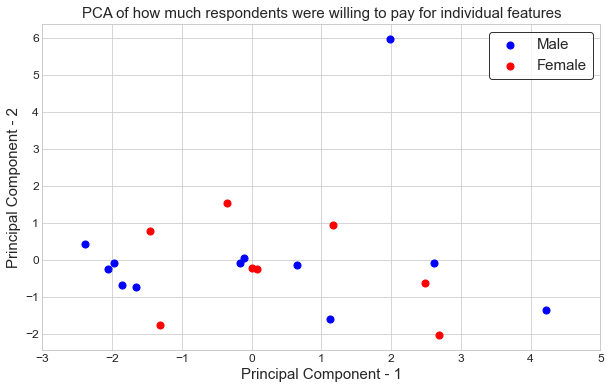

In [12]:
#PCA Plot
plt.figure(figsize=(10, 6))
plt.xlim(left = -3, right = 5)
plt.xlabel('Principal Component - 1')
plt.ylabel('Principal Component - 2')
plt.title("PCA of how much respondents were willing to pay for individual features")

targets = ['Male', 'Female']
colors = ['b', 'r']
for target, color in zip(targets,colors):
    indicesToKeep = willingtopayfeat_df['Gender'] == target
    plt.scatter(principal_willingtopayfeat.loc[indicesToKeep, 'principal component 1'],
                principal_willingtopayfeat.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)

plt.legend(targets, edgecolor='black', frameon=True)

In [13]:
#Applying Association rule learning using apriori algorithm base on results of most wanted features by respondents
#(Note: each respondent could only indicate their 3 most wanted features)

# Defining the hot encoding function to make data suitable 
# for the concerned libraries
def hot_encode(x):
    if(x<= 0):
        return 0
    if(x>= 1):
        return 1

# Encoding the list of features
basket_encoded = mostwantedfeat_df.loc[:, 'Timer':'Extra head'].applymap(hot_encode)
basket_mostwantedfeat = basket_encoded

# Building the model with minimum support = 10%
frq_items = apriori(basket_mostwantedfeat, min_support = 0.1, use_colnames = True)

# Collecting the inferred rules in a dataframe
rules = association_rules(frq_items, metric ="lift", min_threshold = 1)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
rules.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
7,(Style),(Stand),0.238095,0.428571,0.190476,0.800000,1.866667,0.088435,2.857143
2,(Stand),(Rechargeable),0.428571,0.476190,0.285714,0.666667,1.400000,0.081633,1.571429
3,(Rechargeable),(Stand),0.476190,0.428571,0.285714,0.600000,1.400000,0.081633,1.428571
0,(Style),(Rechargeable),0.238095,0.476190,0.142857,0.600000,1.260000,0.029478,1.309524
8,(Battery Indicator),(Stand),0.285714,0.428571,0.142857,0.500000,1.166667,0.020408,1.142857
4,(Battery Indicator),(Rechargeable),0.285714,0.476190,0.142857,0.500000,1.050000,0.006803,1.047619
6,(Stand),(Style),0.428571,0.238095,0.190476,0.444444,1.866667,0.088435,1.371429
9,(Stand),(Battery Indicator),0.428571,0.285714,0.142857,0.333333,1.166667,0.020408,1.071429
1,(Rechargeable),(Style),0.476190,0.238095,0.142857,0.300000,1.260000,0.029478,1.088435
5,(Rechargeable),(Battery Indicator),0.476190,0.285714,0.142857,0.300000,1.050000,0.006803,1.020408


In [14]:
#results from above seem to indicate that the top 3 most wanted features base on the survey is style, stand and rechargeable
#respondents that want a toothbrush with style also would like it to come with a stand 80% of the time
#respondents that want a toothbrush with stand also wants it to be rechargeable 67% of the time